In [116]:
# imports

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [117]:
# Import and check it
df = pd.read_csv('bbc_clean.csv')
df.head()

,text,labels
0,musician tackle u red tape musician group tack...,entertainment
1,u desire number one u three prestigious grammy...,entertainment
2,rocker doherty stage fight rock singer pete do...,entertainment
3,snicket top u box office chart film adaptation...,entertainment
4,ocean twelve raid box office ocean twelve crim...,entertainment


In [118]:
# Check out the labels
df.labels.value_counts()

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [119]:
# Use label encoder to prep the labels for machine learning.

label_encoder = LabelEncoder()
label_encoder.fit(df.labels)
df.labels = label_encoder.transform(df.labels)

In [120]:
# Check it
df.head()

,text,labels
0,musician tackle u red tape musician group tack...,1
1,u desire number one u three prestigious grammy...,1
2,rocker doherty stage fight rock singer pete do...,1
3,snicket top u box office chart film adaptation...,1
4,ocean twelve raid box office ocean twelve crim...,1


In [121]:
# Double check with value counts
df.labels.value_counts()

labels
3    511
0    510
2    417
4    401
1    386
Name: count, dtype: int64

Note the value and order of the label are irrelevant. It matters only that the machine has a numeric target.

In [122]:
# remove the labels from the dataframe for clustering
df_no_labels = df.drop('labels', axis =1)

In [123]:
# Check
df_no_labels.text

0       musician tackle u red tape musician group tack...
1       u desire number one u three prestigious grammy...
2       rocker doherty stage fight rock singer pete do...
3       snicket top u box office chart film adaptation...
4       ocean twelve raid box office ocean twelve crim...
                              ...                        
2220    warn window word file write microsoft word doc...
2221    fast lifts rise record book two high speed lif...
2222    nintendo add medium play d nintendo release ad...
2223    fast move phone virus appear security firm war...
2224    hacker threat apple itunes user apple music ju...
Name: text, Length: 2225, dtype: object

In [162]:
# Use a vectorizer to prep the dataframe for clustering. I'm going to use TF-IDF in this example. 
# I'm also going to limit the document frequency to help

tf_idf = TfidfVectorizer(max_df=.95, min_df=.05)
X_vec = tf_idf.fit_transform(df_no_labels.text)
X_vec = pd.DataFrame.sparse.from_spmatrix(X_vec, columns=tf_idf.get_feature_names_out())
X_vec.head()

,able,accept,access,accord,account,accuse,across,act,action,actor,...,worry,would,write,wrong,xa,xc,year,yet,york,young
0,0,0,0,0,0,0,0.085999,0.257618,0,0,...,0,0.041884,0,0,0.056266,0.056304,0.035877,0,0,0
1,0,0,0,0.047297,0,0,0.055867,0,0,0,...,0,0,0,0,0,0,0.069919,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.05519,0.055228,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0.130694,...,0,0,0,0,0.147674,0.147776,0,0,0,0
4,0,0,0,0.07982,0,0,0.094283,0,0,0,...,0,0,0,0,0.308429,0.308642,0,0,0.10541,0


In [163]:
# Loop through 2-10 clusters, capturing inertia and Silhouette

sil_score = []
in_score = []

for i in range(2,11):
    k_means = KMeans(n_clusters = i)
    k_means.fit(X_vec)
    in_score.append(k_means.inertia_)
    sil_score.append(silhouette_score(X_vec, k_means.labels_))

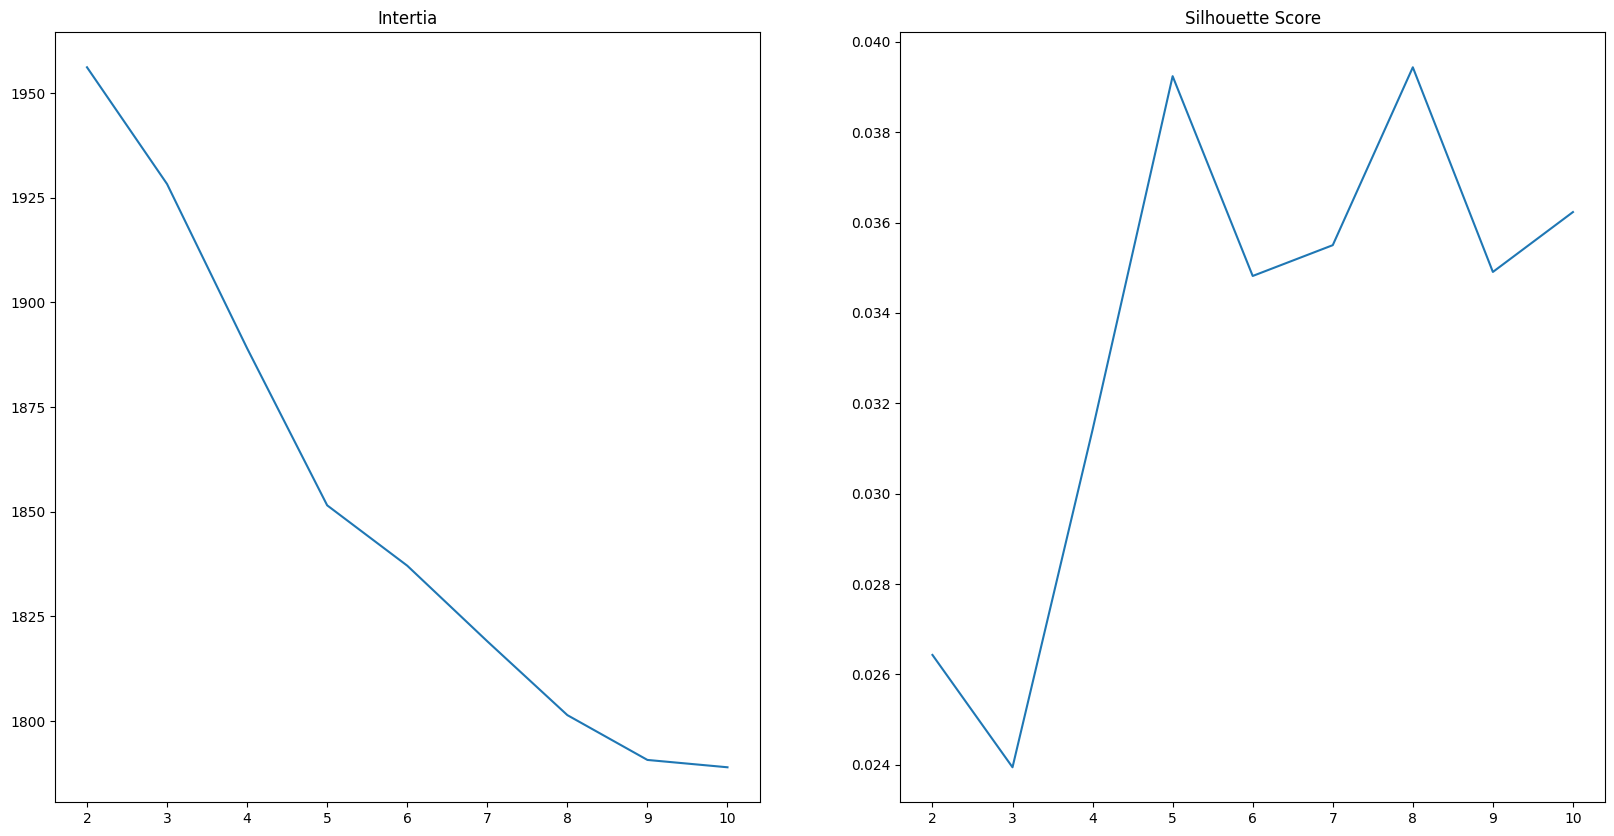

In [164]:
# Graph it!
fix, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.ticklabel_format(style='plain')
ax1.plot(range(2,11),in_score)
ax2.plot(range(2,11),sil_score)
ax1.set_title( 'Intertia')
ax2.set_title('Silhouette Score');


When we look at the Inertia chart, keeping in mind the "elbow" method, it looks like five is a good candidate. 

Looking at the silhouette score, we can see that five has the highest, so we'll use that.

In [165]:
# We are going to instantiate a kmeans model using five clusters. Once we have that, add
# the cluster to the dataframe, as well as the labels.

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_vec)
X_vec['cluster'] = kmeans.labels_
X_vec.head()

,able,accept,access,accord,account,accuse,across,act,action,actor,...,would,write,wrong,xa,xc,year,yet,york,young,cluster
0,0,0,0,0,0,0,0.085999,0.257618,0,0,...,0.041884,0,0,0.056266,0.056304,0.035877,0,0,0,4
1,0,0,0,0.047297,0,0,0.055867,0,0,0,...,0,0,0,0,0,0.069919,0,0,0,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.05519,0.055228,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0.130694,...,0,0,0,0.147674,0.147776,0,0,0,0,3
4,0,0,0,0.07982,0,0,0.094283,0,0,0,...,0,0,0,0.308429,0.308642,0,0,0.10541,0,3


In [166]:
# Prep the data for supervised learning.
X = X_vec
y = df.labels

In [173]:
# TTS!
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [168]:
# Instantiate and fit
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [169]:
# Score!
print(f'The accuracy of train is {lr.score(X_train, y_train)}')
print(f'The accuracy of test is {lr.score(X_test, y_test)}')

The accuracy of train is 0.9724220623501199
The accuracy of test is 0.9299820466786356


In [170]:
# Let us compare that result to a model without using the clustering labels
X_train_2 = X_train.drop('cluster', axis=1)
X_test_2 = X_test.drop('cluster', axis =1)

In [171]:
# Create a new logistic regression model
lr2 = LogisticRegression()
lr2.fit(X_train_2, y_train)

LogisticRegression()

In [172]:
# Score!
print(f'The accuracy of train is {lr2.score(X_train_2, y_train)}')
print(f'The accuracy of test is {lr2.score(X_test_2, y_test)}')

The accuracy of train is 0.9886091127098321
The accuracy of test is 0.940754039497307
